# Ungraded Lab: Variational Autoencoders

This lab will demonstrate all the concepts you learned this week. You will build a Variational Autoencoder (VAE) trained on the MNIST dataset and see how it is able to generate new images. This will be very useful for this week's assignment. Let's begin!

## Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython import display

## Parameters


In [ ]:
# Define global constants to be used in this notebook
BATCH_SIZE=128
LATENT_DIM=2

## Prepare the Dataset

You will just be using the `train` split of the MNIST dataset in this notebook. We've prepared a few helper functions below to help in downloading and preparing the dataset:

* `map_image()` - normalizes and creates a tensor from the image, returning only the image. This will be used for the unsupervised learning in the autoencoder.

* `get_dataset()` - loads MNIST from Tensorflow Datasets, fetching the `train` split by default, then prepares it using the mapping function. If `is_validation` is set to `True`, then it will get the `test` split instead. Training sets will also be shuffled.

In [ ]:
def map_image(image, label):
  '''returns a normalized and reshaped tensor from a given image'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  image = tf.reshape(image, shape=(28, 28, 1,))

  return image


def get_dataset(map_fn, is_validation=False):
  '''Loads and prepares the mnist dataset from TFDS.'''
  if is_validation:
    split_name = "test"
  else:
    split_name = "train"

  dataset = tfds.load('mnist', as_supervised=True, split=split_name)
  dataset = dataset.map(map_fn)

  if is_validation:
    dataset = dataset.batch(BATCH_SIZE)
  else:
    dataset = dataset.shuffle(1024).batch(BATCH_SIZE)

  return dataset

Please run this cell to download and prepare the `train` split of the MNIST dataset.

In [ ]:
train_dataset = get_dataset(map_image)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## Build the Model

You will now be building your VAE model. The main parts are shown in the figure below:

<img src="https://drive.google.com/uc?export=view&id=1YAZAeMGEJ1KgieYk1ju-S9DoshpMREeC" width="60%" height="60%"/>

Like the autoencoder last week, the VAE also has an encoder-decoder architecture with the main difference being the grey box in the middle which stands for the latent representation. In this layer, the model mixes a random sample and combines it with the outputs of the encoder. This mechanism makes it useful for generating new content. Let's build these parts one-by-one in the next sections.

### Sampling Class

First, you will build the `Sampling` class. This will be a custom Keras layer that will provide the Gaussian noise input along with the mean (mu) and standard deviation (sigma) of the encoder's output. In practice, the output of this layer is given by the equation:

$$z = \mu + e^{0.5\sigma} * \epsilon  $$

where $\mu$ = mean, $\sigma$ = standard deviation, and $\epsilon$ = random sample

In [ ]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    """Generates a random sample and combines with the encoder output

    Args:
      inputs -- output tensor from the encoder

    Returns:
      `inputs` tensors combined with a random sample
    """

    # unpack the output of the encoder
    mu, sigma = inputs

    # get the size and dimensions of the batch
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]

    # generate a random tensor
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

    # combine the inputs and noise
    return mu + tf.exp(0.5 * sigma) * epsilon

### Encoder

Next, you will build the encoder part of the network. You will follow the architecture shown in class which looks like this. Note that aside from mu and sigma, you will also output the shape of features before flattening it. This will be useful when reconstructing the image later in the decoder.

*Note:* You might encounter issues with using batch normalization with smaller batches, and sometimes the advice is given to avoid using batch normalization when training VAEs in particular. Feel free to experiment with adding or removing it from this notebook to explore the effects.

<img src="https://drive.google.com/uc?export=view&id=1eoxFK_UVSHd3a_5EHcCU8F8QDZlPiXfW" width="60%" height="60%"/>

In [ ]:
def encoder_layers(inputs, latent_dim):
  """Defines the encoder's layers.
  Args:
    inputs -- batch from the dataset
    latent_dim -- dimensionality of the latent space

  Returns:
    mu -- learned mean
    sigma -- learned standard deviation
    batch_2.shape -- shape of the features before flattening
  """

  # add the Conv2D layers followed by BatchNormalization
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation='relu', name="encode_conv1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="encode_conv2")(x)

  # assign to a different variable so you can extract the shape later
  batch_2 = tf.keras.layers.BatchNormalization()(x)

  # flatten the features and feed into the Dense network
  x = tf.keras.layers.Flatten(name="encode_flatten")(batch_2)

  # we arbitrarily used 20 units here but feel free to change and see what results you get
  x = tf.keras.layers.Dense(20, activation='relu', name="encode_dense")(x)
  x = tf.keras.layers.BatchNormalization()(x)

  # add output Dense networks for mu and sigma, units equal to the declared latent_dim.
  mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)
  sigma = tf.keras.layers.Dense(latent_dim, name ='latent_sigma')(x)

  return mu, sigma, batch_2.shape

With the encoder layers defined, you can declare the encoder model that includes the `Sampling` layer with the function below:

In [ ]:
def encoder_model(latent_dim, input_shape):
  """Defines the encoder model with the Sampling layer
  Args:
    latent_dim -- dimensionality of the latent space
    input_shape -- shape of the dataset batch

  Returns:
    model -- the encoder model
    conv_shape -- shape of the features before flattening
  """

  # declare the inputs tensor with the given shape
  inputs = tf.keras.layers.Input(shape=input_shape)

  # get the output of the encoder_layers() function
  mu, sigma, conv_shape = encoder_layers(inputs, latent_dim=LATENT_DIM)

  # feed mu and sigma to the Sampling layer
  z = Sampling()((mu, sigma))

  # build the whole encoder model
  model = tf.keras.Model(inputs, outputs=[mu, sigma, z])

  return model, conv_shape

### Decoder

Next, you will build the decoder part of the network which expands the latent representations back to the original image dimensions. As you'll see later in the training loop, you can feed random inputs to this model and it will generate content that resemble the training data.

In [ ]:
def decoder_layers(inputs, conv_shape):
  """Defines the decoder layers.
  Args:
    inputs -- output of the encoder
    conv_shape -- shape of the features before flattening

  Returns:
    tensor containing the decoded output
  """

  # feed to a Dense network with units computed from the conv_shape dimensions
  units = conv_shape[1] * conv_shape[2] * conv_shape[3]
  x = tf.keras.layers.Dense(units, activation = 'relu', name="decode_dense1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  # reshape output using the conv_shape dimensions
  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name="decode_reshape")(x)

  # upsample the features back to the original dimensions
  x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_2")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_3")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid', name="decode_final")(x)

  return x

You can define the decoder model as shown below.

In [ ]:
def decoder_model(latent_dim, conv_shape):
  """Defines the decoder model.
  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening

  Returns:
    model -- the decoder model
  """

  # set the inputs to the shape of the latent space
  inputs = tf.keras.layers.Input(shape=(latent_dim,))

  # get the output of the decoder layers
  outputs = decoder_layers(inputs, conv_shape)

  # declare the inputs and outputs of the model
  model = tf.keras.Model(inputs, outputs)

  return model

### Kullback–Leibler Divergence

To improve the generative capability of the model, you have to take into account the random normal distribution introduced in the latent space. For that, the [Kullback–Leibler Divergence](https://arxiv.org/abs/2002.07514) is computed and added to the reconstruction loss. The formula is defined in the function below.

In [ ]:
def kl_reconstruction_loss(mu, sigma):
  """ Computes the Kullback-Leibler Divergence (KLD)
  Args:
    mu -- mean
    sigma -- standard deviation

  Returns:
    KLD loss
  """
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  kl_loss = tf.reduce_mean(kl_loss) * -0.5

  return kl_loss

You can now define the entire VAE model. Note the use of `model.add_loss()` to add the KL reconstruction loss. Computing this loss doesn't use `y_true` and `y_pred` so it can't be used in `model.compile()`.

In [ ]:
def vae_model(encoder, decoder, input_shape):
  """Defines the VAE model
  Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

  Returns:
    the complete VAE model
  """

  # set the inputs
  inputs = tf.keras.layers.Input(shape=input_shape)

  # get mu, sigma, and z from the encoder output
  mu, sigma, z = encoder(inputs)

  # get reconstructed output from the decoder
  reconstructed = decoder(z)

  # define the inputs and outputs of the VAE
  model = tf.keras.Model(inputs=inputs, outputs=reconstructed)

  # add the KL loss
  loss = kl_reconstruction_loss(mu, sigma)
  model.add_loss(loss)

  return model

We'll add a helper function to setup and get the different models from the functions you defined.

In [ ]:
def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""
  encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
  decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
  vae = vae_model(encoder, decoder, input_shape=input_shape)
  return encoder, decoder, vae

In [ ]:
# Get the encoder, decoder and 'master' model (called vae)
encoder, decoder, vae = get_models(input_shape=(28,28,1,), latent_dim=LATENT_DIM)

## Train the Model

You can now setup the VAE model for training. Let's start by defining the reconstruction loss, optimizer and metric.

In [ ]:
# Define our loss functions and optimizers
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()

You will want to see the progress of the image generation at each epoch. For that, you can use the helper function below. This will generate 16 images in a 4x4 grid.

In [ ]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """

  # generate images from the test input
  predictions = model.predict(test_input)

  # plot the results
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

The training loop is shown below. This will display generated images each epoch and will take around 30 minutes to complete. Notice too that we add the KLD loss to the binary crossentropy loss before we get the gradients and update the weights.

As you might expect, the initial 16 images will look random but it will improve overtime as the network learns and you'll see images that resemble the MNIST dataset.

1/1 [==============================] - 0s 18ms/step


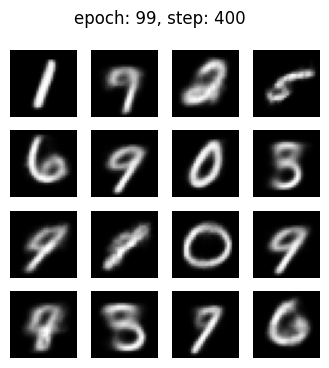

Epoch: 99 step: 400 mean loss = 144.95622


In [16]:
# Training loop.

# generate random vector as test input to the decoder
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

# number of epochs
epochs = 100

# initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:

      # feed a batch to the VAE model
      reconstructed = vae(x_batch_train)

      # compute reconstruction loss
      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = bce_loss(flattened_inputs, flattened_outputs) * 784

      # add KLD regularization loss
      loss += sum(vae.losses)

    # get the gradients and update the weights
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    # compute the loss metric
    loss_metric(loss)

    # display outputs every 100 steps
    if step % 100 == 0:
      display.clear_output(wait=False)
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
      print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))